In [1]:
import _config

%cd ..

from continual_learning.continual_metrics import compute_continual_metrics
from search_space import get_search_space, ModelSample
from tools.post_search import (
    get_archive_best_models,
    get_model_flatness,
    get_best_archive,
)

import matplotlib.pyplot as plt
import numpy as np
import json
import os
import re

BASE_DIR = "nas-results"


/Users/vvcastro/Research/continual_nas/repo


Get the experiment data:

In [2]:
DATASET_NAME = "cifar10"
MODEL_TYPE = "growing"

NAS_TYPE = "multi-objective"

In [3]:
def get_experiment_best_archives(dataset: str, model_type: str):
    # Get the experiments matching the dataset and model type
    _basedir = os.path.join(BASE_DIR, f"efficient-{dataset}")
    experiments_dirs = [
        dir for dir in os.listdir(_basedir) if f"{model_type}-seed" in dir
    ]

    # Get the seeds available for each experiment
    seeds = [int(re.search(r"\d+", dir).group()) for dir in experiments_dirs]

    # Load the the last archive for each experiment
    last_archives, archive_seeds = [], []

    for seed in seeds:
        try:
            seed_archive = get_best_archive(BASE_DIR, dataset, model_type, seed)
            last_archives.append(seed_archive)
            archive_seeds.append(seed)
        except FileNotFoundError:
            continue

    return last_archives, archive_seeds


def get_best_models_from_archive(archive: dict, n_best: int):
    archive_models = [datum["sample"] for datum in archive]
    archive_metrics = np.stack([datum["metrics"] for datum in archive])

    # Get the best models from the archive
    best_models, best_metrics = get_archive_best_models(
        archive_models, archive_metrics, n_best=50
    )

    # Get the model with the best accuracy
    best_accuracy_idx = np.argmax(best_metrics[:, 0])
    best_accuracy_model = best_models[best_accuracy_idx]
    return best_accuracy_model, best_metrics[best_accuracy_idx]


Get the best models and their metrics:

In [4]:
last_archives, seeds = get_experiment_best_archives(DATASET_NAME, MODEL_TYPE)

best_accuracies, best_flatnesses = [], []
best_models = []

for archive, seed in zip(last_archives, seeds):
    best_model, best_metrics = get_best_models_from_archive(archive, 5)
    best_accuracies.append(best_metrics[0])
    best_flatnesses.append(best_metrics[1])
    best_models.append(best_model)

Iterate over the models to compute the rest of the metrics from the `fixed` base model:

In [5]:
import subprocess

def test_model(test_dir: str, model: ModelSample, model_type: str, seed: int):
    search_space = get_search_space("mobilenetv3", model_type == "fixed")

    # Build the evaluator run params
    model_encoding = search_space.encode(model)
    params = [
        "python",
        "scripts-nas/_tester.py",
        "--experiment_dir",
        str(test_dir),
        "--model_encoding",
        *map(str, model_encoding),
        "--dataset",
        str(DATASET_NAME),
        "--n_tasks",
        "5",
        "--epochs_per_task",
        "1",
        "--architecture",
        str("expandable" if model_type == "growing" else "fixed"),
        "--random_seed",
        str(seed),
    ]

    # Execute the script
    subprocess.run(params, check=True)

Evaluate the models as describe in the thesis:

In [7]:
# Define a direction to store the results
DIRECTION_TEST_RESULTS_DIR = os.path.join(
    "nas-tester",
    f"efficient-{DATASET_NAME}",
    "directions",
)

# Test each model in a FIXED architecture
for best_model, seed in zip(best_models, seeds):
    model_results_dir = os.path.join(DIRECTION_TEST_RESULTS_DIR, f"{MODEL_TYPE}-seed{seed}")
    test_model(model_results_dir, best_model, "fixed", seed)

Model 1111000001100011000100000000110000000010000008-44 already trained, skipping...
Model 1111001001110001100100001001100010100000000004-43 already trained, skipping...
Model 0010010000100010001100001101100011101001011106-42 already trained, skipping...


Test the models with all the other directions:

In [36]:
all_directions = [
    [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1],
]

for best_model, seed in zip(best_models, seeds):
    direction_results_dir = os.path.join(
        DIRECTION_TEST_RESULTS_DIR, f"{MODEL_TYPE}-seed{seed}"
    )

    # Replace model direction with the current direction
    for direction in all_directions:

        # Avoid testing the same direction twice
        if (direction == best_model["direction"]):
            continue

        print("Iterating direction:", direction)
        best_model["direction"] = direction
        test_model(direction_results_dir, best_model, "growing", seed)

Iterating direction: [0, 0, 0]
Model 1111000001100011000100000000110000000010000008000-44 already trained, skipping...
Iterating direction: [1, 0, 0]
Model 1111000001100011000100000000110000000010000008100-44 already trained, skipping...
Iterating direction: [0, 1, 0]
Model 1111000001100011000100000000110000000010000008010-44 already trained, skipping...
Iterating direction: [0, 0, 1]
Model 1111000001100011000100000000110000000010000008001-44 already trained, skipping...
Iterating direction: [1, 1, 0]
Model 1111000001100011000100000000110000000010000008110-44 already trained, skipping...
Iterating direction: [1, 0, 1]
Model 1111000001100011000100000000110000000010000008101-44 already trained, skipping...
Iterating direction: [0, 1, 1]
Model 1111000001100011000100000000110000000010000008011-44 already trained, skipping...
Iterating direction: [1, 1, 1]
Model 1111000001100011000100000000110000000010000008111-44 already trained, skipping...
Iterating direction: [0, 0, 0]
Model 11110010011

Load the metrics for each model:

In [75]:
# Store the metrics for each model
direction_metrics = {
    "NAS": [],
    "None": [],
    "Zero": [],
    "Other": [],
}

# Find all the evaluated models from the directory
evaluated_experiments = os.listdir(DIRECTION_TEST_RESULTS_DIR)
for experiment_dir in evaluated_experiments:
    experiment_path = os.path.join(DIRECTION_TEST_RESULTS_DIR, experiment_dir, "models")
    evaluated_models = os.listdir(experiment_path)
    print("Number of evaluated models:", len(evaluated_models))

    # Get the optimal model for this seed experiment
    _, seed, _ = experiment_dir.split("-")
    seed_id = int(seed.lstrip("seed"))
    experiment_model = best_models[seeds.index(seed_id)]

    # Get the direction encoded as in the search space
    _direction = experiment_model["direction"]
    experiment_direction = "".join(map(str, _direction))
    print("Experiment direction:", experiment_direction)

    # Read the models metrics
    for model_dir in evaluated_models:
        model_path = os.path.join(experiment_path, model_dir)
        history_path = os.path.join(model_path, "history.json")

        # Read the training history file
        with open(history_path, "r") as f:
            model_history = json.load(f)

        # Get the metrics from the history
        model_metrics = compute_continual_metrics(model_history)
        model_flatness = [ t["flatness"][-1] for t in model_history["training_metrics"]["validation"].values() ]
        model_metrics["flatness"] = np.array([np.mean(model_flatness)])
        # Get the model direction
        model_name, seed = model_dir.split("-")
        if (len(model_name) < 47):
            model_direction = None
        else:
            model_direction = model_name[-3:]

        # Aggregate to the correct group of models
        if model_direction == experiment_direction:
            direction_metrics["NAS"].append(model_metrics)
        elif model_direction is None:
            direction_metrics["None"].append(model_metrics)
        elif model_direction == "000":
            direction_metrics["Zero"].append(model_metrics)
        else:
            direction_metrics["Other"].append(model_metrics)

# Aggregate the metrics over the groups
for group in direction_metrics:
    group_metrics = direction_metrics[group]
    metric_keys = group_metrics[0].keys()

    # Aggregate the metrics
    metrics_mean, metrics_std = {}, {}
    for metric in metric_keys:
        metrics_mean[metric] = np.mean(
            [metrics[metric] for metrics in group_metrics],
            axis=0
        )
        metrics_std[metric] = np.std(
            [metrics[metric] for metrics in group_metrics],
            axis=0
        )
    direction_metrics[group] = {
        "mean": metrics_mean,
        "std": metrics_std,
    }


Number of evaluated models: 9
Experiment direction: 001
Number of evaluated models: 9
Experiment direction: 011
Number of evaluated models: 9
Experiment direction: 010


Plot the metrics:

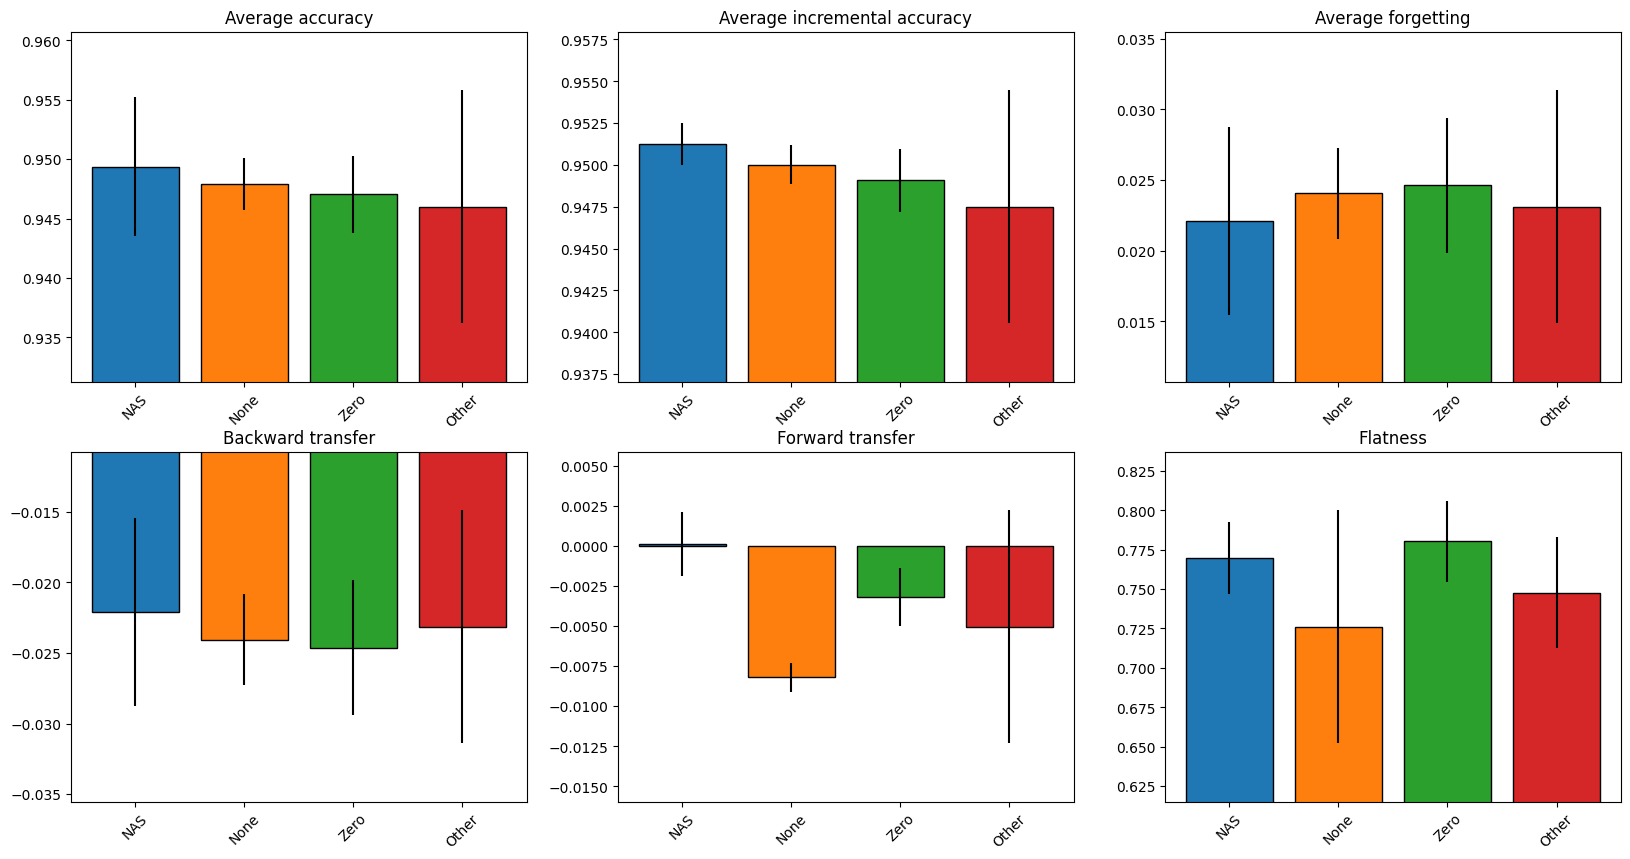

In [79]:
# All the available metric groups
groups = list(direction_metrics.keys())
incremental_metrics = direction_metrics[groups[0]]["mean"].keys()

# Define a color map for the groups
colors = plt.cm.tab10.colors
group_colors = {group: colors[i % len(colors)] for i, group in enumerate(groups)}

plt.figure(figsize=(20, 10))

for i, metric in enumerate(incremental_metrics):
    ax = plt.subplot(2, 3, i + 1)

    group_means, group_stds, bar_colors = [], [], []

    min_metric, max_metric = np.inf, -np.inf
    for group in groups:
        # Get the mean and std for the current metric
        means = direction_metrics[group]["mean"][metric][-1]
        stds = direction_metrics[group]["std"][metric][-1]

        # Store the min and max metric values
        min_metric = min(min_metric, means - 1.5*stds)
        max_metric = max(max_metric, means + 1.5*stds)

        group_means.append(means)
        group_stds.append(stds)
        bar_colors.append(group_colors[group])

    bars = ax.bar(
        np.arange(len(groups)),
        group_means,
        yerr=group_stds,
        color=bar_colors,
        edgecolor="black",
    )

    ax.set_ylim(min_metric, max_metric)
    ax.set_title(' '.join(metric.split('_')).capitalize())
    ax.set_xticks(np.arange(len(groups)))

    # Format the x-axis labels
    ax.set_xticklabels(groups, rotation=45)

plt.savefig("direction_optimality.png", dpi=300)
plt.tight_layout()
plt.show()



Plot the training curves:

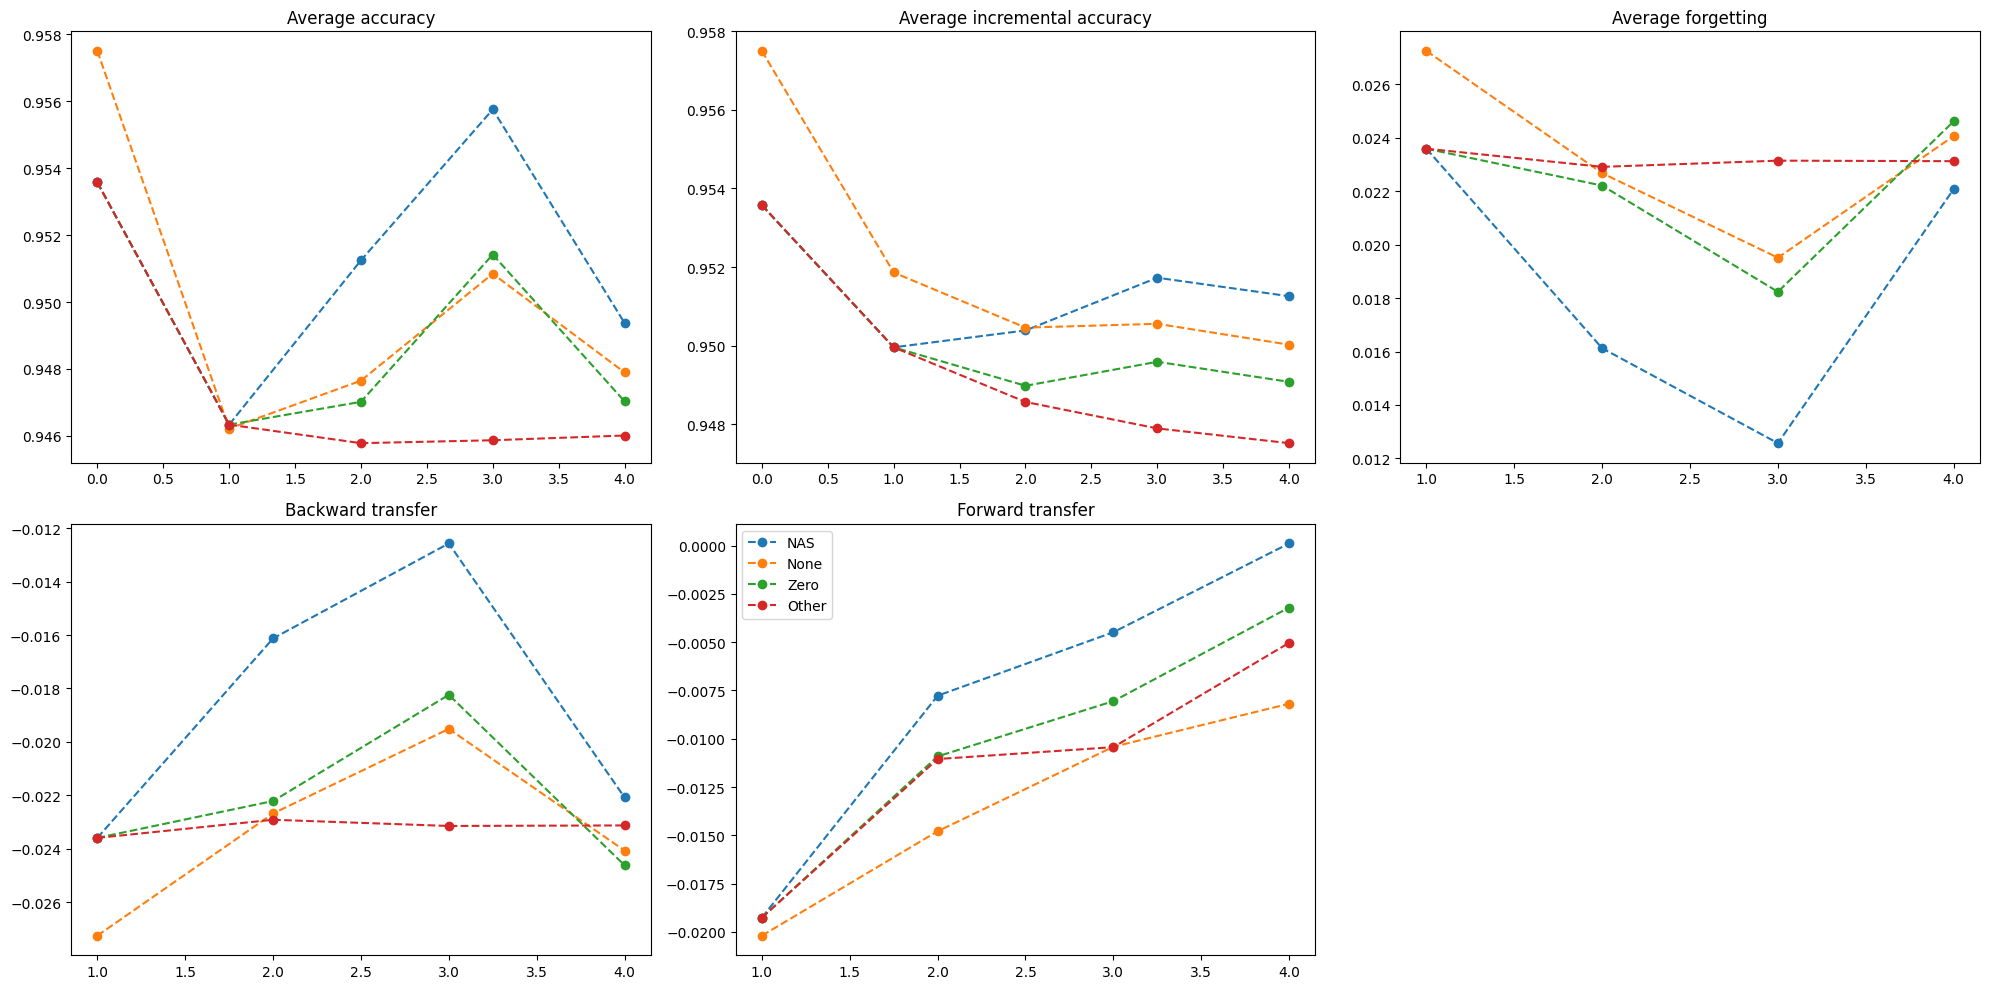

In [87]:
# All the available metric groups
groups = list(direction_metrics.keys())
incremental_metrics = list(direction_metrics[groups[0]]["mean"].keys())
incremental_metrics.remove("flatness")

# Define a color map for the groups
colors = plt.cm.tab10.colors
group_colors = {group: colors[i % len(colors)] for i, group in enumerate(groups)}

plt.figure(figsize=(20, 10))

for i, metric in enumerate(incremental_metrics):
    ax = plt.subplot(2, 3, i + 1)

    group_means, group_stds, bar_colors = [], [], []

    min_metric, max_metric = np.inf, -np.inf
    for group in groups:
        # Get the mean and std for the current metric
        means = direction_metrics[group]["mean"][metric]
        stds = direction_metrics[group]["std"][metric]

        ax.plot(
            means,
            color=group_colors[group],
            label=group,
            marker="o",
            linestyle="--",
        )

    # ax.set_ylim(min_metric, max_metric)
    ax.set_title(" ".join(metric.split("_")).capitalize())

# plt.savefig("direction_optimality.png", dpi=300)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
